##Задание 4


In [ ]:
%matplotlib inline
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch import nn
from torchsummary import summary
from torch import optim
from IPython.display import clear_output
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## Аугментации (случайные сдвиги, случайные повороты, горизонтальное отражение)

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomAffine(0, translate=(0.2, 0.2)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.ToTensor()
])

In [ ]:
train_dataset = datasets.FashionMNIST(root='fashion_mnist', train=True, download=True, transform=train_transform)
test_dataset = datasets.FashionMNIST(root='fashion_mnist', train=False, download=True, transform=test_transform)

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 201kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.76MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 30.2MB/s]


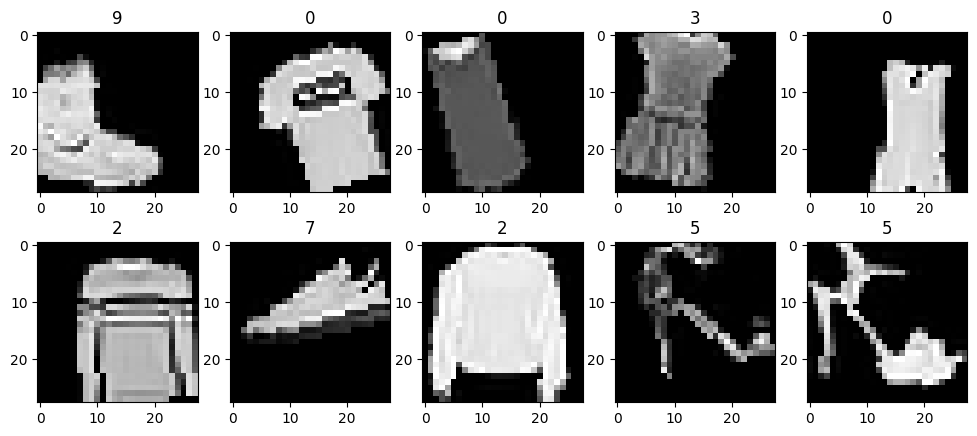

In [ ]:
plt.figure(figsize=(12,5))

for i in range(10):
    x, y = train_dataset[i]
    x = x.squeeze().numpy()
    plt.subplot(2, 5, i + 1)
    plt.title(f'{y}')
    plt.imshow(x, cmap='gray')

plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
print(f"Используемое устройство: {device}")

Используемое устройство: cpu


In [ ]:
def run(model, dataloader, loss_function, optimizer=None):
    if optimizer == None:
        model.eval()
    else:
        model.train()
    total_loss = 0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_function(pred, y)
        total_loss += loss.item()
        if optimizer != None:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    return total_loss / len(dataloader)

In [ ]:
def show_losses(train_loss_hist, test_loss_hist):
    clear_output()

    plt.figure(figsize=(10,3))

    plt.subplot(1, 2, 1)
    plt.title('Train Loss')
    plt.plot(np.arange(len(train_loss_hist)), train_loss_hist)
    plt.yscale('log')
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.title('Test Loss')
    plt.plot(np.arange(len(test_loss_hist)), test_loss_hist)
    plt.yscale('log')
    plt.grid()

    plt.show()

In [ ]:
def compute_metrics(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            preds = model(X)
            pred_labels = preds.argmax(dim=1).cpu().numpy()
            labels = y.cpu().numpy()
            all_preds.extend(pred_labels)
            all_labels.extend(labels)

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return accuracy, precision, recall, f1

## Сверточная сеть CNN (16-32-64) + Skip-connection между 2-м и 3-м свёрточными блоками + Полносвязная сеть (256-128-64-32) с Dropout


In [ ]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.skip_conv = nn.Conv2d(32, 64, kernel_size=1)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 3 * 3, 256)
        self.relu_fc1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.25)

        self.fc2 = nn.Linear(256, 128)
        self.relu_fc2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.25)

        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        skip = self.skip_conv(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = x + skip

        x = self.pool3(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu_fc1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu_fc2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

model = Model().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           4,640
              ReLU-5           [-1, 32, 14, 14]               0
         MaxPool2d-6             [-1, 32, 7, 7]               0
            Conv2d-7             [-1, 64, 7, 7]           2,112
            Conv2d-8             [-1, 64, 7, 7]          18,496
              ReLU-9             [-1, 64, 7, 7]               0
        MaxPool2d-10             [-1, 64, 3, 3]               0
          Flatten-11                  [-1, 576]               0
           Linear-12                  [-1, 256]         147,712
             ReLU-13                  [-1, 256]               0
          Dropout-14                  [

In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-1)

## Обучение модели (20 эпох)

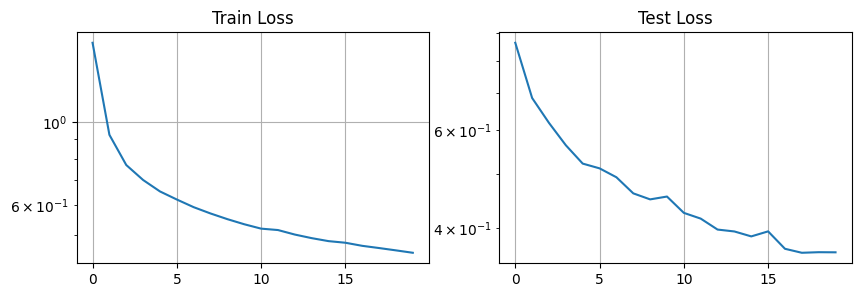

In [ ]:
BATCH_SIZE = 100
NUM_EPOCHS = 20

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

train_loss_hist = []
test_loss_hist = []

for i in range(NUM_EPOCHS):
    train_loss = run(model, train_loader, loss_function, optimizer)
    train_loss_hist.append(train_loss)
    test_loss = run(model, test_loader, loss_function)
    test_loss_hist.append(test_loss)

    if i % 2 == 1:
        show_losses(train_loss_hist, test_loss_hist)

In [ ]:
accuracy, precision, recall, f1 = compute_metrics(model, test_loader)

print("Accuracy (Test):", accuracy)
print("Precision (Test):", precision)
print("Recall (Test):", recall)
print("F1 Score (Test):", f1)

min_loss = min(test_loss_hist)
print("Минимальная ошибка (Test Loss):", min_loss)

Accuracy (Test): 0.8647
Precision (Test): 0.8662924034276009
Recall (Test): 0.8647
F1 Score (Test): 0.8587749264393165
Минимальная ошибка (Test Loss): 0.36098519861698153


## Выводы
В данной модели добавлен skip connection, который позволяет модели пропускать промежуточный слой. Данное изменение помогает модели более гибко обучаться. На практике данный метод позволил улучшить метрики лишь незначительно. Это связано с небольшим количеством слоев модели, так как данный метод эффиктивен для более глубоких моделей.

В результате простая сверточная сеть показала лучшие значения метрик, так как смогла хорошо обучиться за достаточно небольшое количество эпох.